In [23]:
import tensorflow as tf
import tensorflow
import sklearn
import math
import keras
import numpy
import pandas
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.image as mpimg
from keras.utils import np_utils
import matplotlib.pyplot
from keras.models import Sequential,Model
from keras.losses import mse,sparse_categorical_crossentropy
from keras.layers import Dense, Conv2D, Conv1D, Conv3D, Flatten,Activation,MaxPool1D,MaxPooling1D,Dropout,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.layers import Lambda, Input, Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard

In [24]:
img_size1 = 4
img_size2 = 1
num_channels = 1
latent_space_dim =24
num_category=3

In [25]:
# RNN
model_rnn = Sequential()
model_rnn.add(LSTM(units=32, input_shape=(img_size1, img_size2), return_sequences=True))
model_rnn.add(MaxPooling1D(2))
model_rnn.add(LSTM(units=64, return_sequences=True))
model_rnn.add(MaxPooling1D(2))
model_rnn.add(LSTM(units=64, return_sequences=True))
model_rnn.add(MaxPooling1D(1))
model_rnn.add(LSTM(units=64))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(latent_space_dim, name='feature_extraction'))
model_rnn.add(Dense(num_category, activation='softmax'))
model_rnn.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4, 32)             4352      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 2, 64)             24832     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)               

In [26]:
##########################################   préparation des données #######################################
datasetf2001 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2001.csv')
data2001=np.array(datasetf2001.iloc[:, 2:6])
datay=np.array(datasetf2001.iloc[:, 6:7])
x_train2001, x_test2001 = train_test_split(data2001, test_size = 0.3, random_state = 0)
y_train, y_test = train_test_split(datay, test_size = 0.3, random_state = 0)
x_train2001 = numpy.reshape(x_train2001, newshape=( x_train2001.shape[0], x_train2001.shape[1],1))
x_test2001 = numpy.reshape(x_test2001, newshape=( x_test2001.shape[0], x_test2001.shape[1],1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
data2001.shape

(520873, 4)

In [27]:
##########################################   préparation des données #######################################
datasetf2004 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2004.csv')
data2004=np.array(datasetf2004.iloc[:, 2:6])
x_train2004, x_test2004 = train_test_split(data2004, test_size = 0.3, random_state = 0)
x_train2004 = numpy.reshape(x_train2004, newshape=(x_train2004.shape[0], x_train2004.shape[1],1))
x_test2004 = numpy.reshape(x_test2004, newshape=( x_test2004.shape[0], x_test2004.shape[1],1))
data2004.shape

(520873, 4)

In [28]:
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5)
hist=model_rnn.fit(x_train2001, y_train, epochs=1000, batch_size=256,callbacks=[es])

Epoch 1/1000
1425/1425 [==============================] - 43s 13ms/step - loss: 0.6694 - accuracy: 0.6715
Epoch 2/1000
1425/1425 [==============================] - 19s 14ms/step - loss: 0.3281 - accuracy: 0.8529
Epoch 3/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.2953 - accuracy: 0.8680
Epoch 4/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.2840 - accuracy: 0.8734
Epoch 5/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.2571 - accuracy: 0.8875
Epoch 6/1000
1425/1425 [==============================] - 20s 14ms/step - loss: 0.2145 - accuracy: 0.9080
Epoch 7/1000
1425/1425 [==============================] - 20s 14ms/step - loss: 0.2094 - accuracy: 0.9103
Epoch 8/1000
1425/1425 [==============================] - 19s 14ms/step - loss: 0.2055 - accuracy: 0.9106
Epoch 9/1000
1425/1425 [==============================] - 19s 14ms/step - loss: 0.2045 - accuracy: 0.9115
Epoch 10/1000
1425/1425 [=====================

In [29]:
feature_extraction = Model(inputs=model_rnn.input,outputs=model_rnn.get_layer('feature_extraction').output)
weights = feature_extraction.get_weights()
for l in feature_extraction.layers:
    l.trainable = False
    print(l.name, l.trainable)
# re-compile the model
feature_extraction.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

lstm_12_input False
lstm_12 False
max_pooling1d_9 False
lstm_13 False
max_pooling1d_10 False
lstm_14 False
max_pooling1d_11 False
lstm_15 False
dropout_1 False
feature_extraction False


In [30]:
rnn_in_1 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2), name="s_input1")
rnn_in_2 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2), name="s_input2")
concatted = tf.keras.layers.Concatenate()([feature_extraction(rnn_in_1), feature_extraction(rnn_in_2)])
prediction = Dense(num_category, activation='softmax', name="classifier")(concatted)
Siamese_rnn=Model(inputs=[rnn_in_1,rnn_in_2],outputs=prediction)
Siamese_rnn.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
Siamese_rnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s_input1 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
s_input2 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 24)           96792       s_input1[0][0]                   
                                                                 s_input2[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 48)           0           model[0][0]                

In [31]:
##########################################   Siamese RNN Training #######################################
import time
start_time = time.time()
ces = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
history=Siamese_rnn.fit([x_train2001,x_train2004],y_train,batch_size=256,epochs=1000,callbacks=[ces]) 
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/1000
1425/1425 [==============================] - 47s 7ms/step - loss: 0.1386 - accuracy: 0.9484
Epoch 2/1000
1425/1425 [==============================] - 10s 7ms/step - loss: 0.1052 - accuracy: 0.9583
Epoch 3/1000
1425/1425 [==============================] - 10s 7ms/step - loss: 0.1013 - accuracy: 0.9596
Epoch 4/1000
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0996 - accuracy: 0.9605
Epoch 5/1000
1425/1425 [==============================] - 9s 6ms/step - loss: 0.0988 - accuracy: 0.9607
Epoch 6/1000
1425/1425 [==============================] - 8s 5ms/step - loss: 0.0977 - accuracy: 0.9611
Epoch 7/1000
1425/1425 [==============================] - 9s 6ms/step - loss: 0.0974 - accuracy: 0.9614
Epoch 8/1000
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0966 - accuracy: 0.9618
Epoch 9/1000
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0964 - accuracy: 0.9617
Epoch 10/1000
1425/1425 [==============================] - 8s

dict_keys(['loss', 'accuracy'])


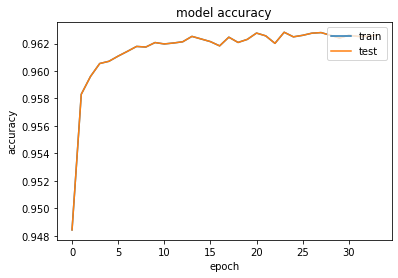

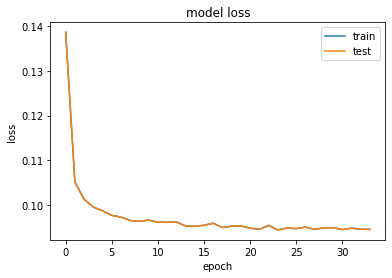

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
data2001 = numpy.reshape(data2001, newshape=(data2001.shape[0], data2001.shape[1],1,1))
data2004 = numpy.reshape(data2004, newshape=(data2004.shape[0], data2004.shape[1],1,1))
Y_pred=Siamese_rnn.predict([data2001,data2004])
datasetvae2001_class = pd.DataFrame(datasetf2001['x'])
datasetvae2004_class = pd.DataFrame(datasetf2001['x'])
datasetvae2001_class['y'] = pd.DataFrame(datasetf2001['y'],columns=['y'])
datasetvae2004_class['y'] = pd.DataFrame(datasetf2001['y'],columns=['y'])
datasetvae2001_class['f1'] = pd.DataFrame(datasetf2001['f1'])
datasetvae2001_class['f2'] = pd.DataFrame(datasetf2001['f2'])
datasetvae2001_class['f3'] = pd.DataFrame(datasetf2001['f3'])
datasetvae2001_class['f4'] = pd.DataFrame(datasetf2001['f4'])
datasetvae2004_class['f1'] = pd.DataFrame(datasetf2004['f1'])
datasetvae2004_class['f2'] = pd.DataFrame(datasetf2004['f2'])
datasetvae2004_class['f3'] = pd.DataFrame(datasetf2004['f3'])
datasetvae2004_class['f4'] = pd.DataFrame(datasetf2004['f4'])
datasetvae2001_class['class'] = datay
datasetvae2001_class['pred'] = np.argmax(Y_pred, axis=1)
datasetvae2001_class.to_csv(r'D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/y_pred_insitu_MH_2001_rnn.csv')
datasetvae2004_class['class'] = datay
datasetvae2004_class['pred'] = np.argmax(Y_pred, axis=1)
datasetvae2004_class.to_csv(r'D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/y_pred_insitu_MH_2004_rnn.csv')

In [34]:
mse = sklearn.metrics.mean_squared_error(datay, np.argmax(Y_pred, axis=1))
rmse = math.sqrt(mse)
r2=sklearn.metrics.r2_score(datay, np.argmax(Y_pred, axis=1))
precision_sc=sklearn.metrics.precision_score(datay, np.argmax(Y_pred, axis=1), average='macro')
f1_sc=sklearn.metrics.f1_score(datay, np.argmax(Y_pred, axis=1), average='macro')
confusion_mat=sklearn.metrics.confusion_matrix(datay, np.argmax(Y_pred, axis=1))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(datay, np.argmax(Y_pred, axis=1), pos_label=2)
auc=sklearn.metrics.auc(fpr, tpr)
from sklearn.metrics import recall_score
recall_score=recall_score(datay, np.argmax(Y_pred, axis=1), average=None)

In [35]:
recall_score

array([0.96608803, 0.96684923, 0.96848116])

In [36]:
mse

0.10294831945599023

In [37]:
rmse

0.32085560530554896

In [38]:
r2

0.8807882025522469

In [39]:
precision_sc

0.9659928417194275

In [40]:
f1_sc

0.9665572363524518

In [41]:
fpr

array([0.        , 0.03367965, 0.2715579 , 1.        ])

In [42]:
tpr

array([0.        , 0.96848116, 0.97880142, 1.        ])

In [43]:
auc

0.968638269741318

In [44]:
from sklearn.metrics import accuracy_score
accuracy=sklearn.metrics.accuracy_score(datay, np.argmax(Y_pred, axis=1))
accuracy*100

96.73528864041715

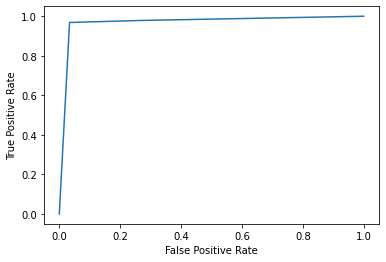

In [45]:
from sklearn.metrics import RocCurveDisplay
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

<AxesSubplot:>

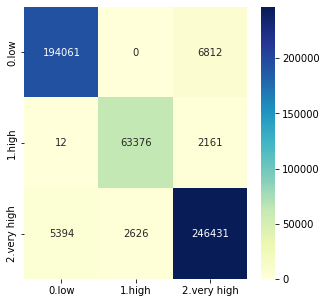

In [46]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index = ["0.low","1.high","2.very high"],columns = ["0.low","1.high","2.very high"])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")